## WB2 - FFN

The feature extraction process is based on this [blog](http://aqibsaeed.github.io/2016-09-03-urban-sound-classification-part-1/)

Some functions will be used that were previously defined in WB1

In [132]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [118]:
def load_files(file_paths, sr):
    waves = []
    for path in file_paths:
        X,sr = librosa.load(path, sr=sr)
        waves.append(X)
    return waves

As described in the blog post, we are about to do dimensionality reduction of audio using feature extraction methods provided by the Python library librosa. The feature extractions methods involved are:

- MFCC: representation of the short-term power spectrum of a sound
- Mel-frequency cepstral coefficients: Coefficients that collectively make up an mel-frequency cepstrum
- Chromagram of a short-time Fourier transform: Projects into bins representing the 12 distinct semitones of the musical octave
- Octave-based spectral contrast: Distribution of sound energy over octave frequencies 
- Tonnetz: Estimates tonal centroids features

Combining these 5 feature extractions will result in a vector of 193 values. Is important to remark that this vector will always have the same length even if the audio files are of different length. 

In [119]:
def extract_features(file_name):
    X, sr = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sr).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sr).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

def parse_file(filename):
    mfccs, chroma, mel, contrast, tonnetz = extract_features(filename)
    features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
    return features

Now lets test the dimensionality reduction with a sample file

In [120]:
def run_sample(filename):
    mfccs, chroma, mel, contrast, tonnetz = extract_features(filename)
    all_features = np.hstack((mfccs,chroma,mel,contrast,tonnetz))
    print "MFCSS  = ", len(mfccs)
    print "Chroma = ", len(chroma)
    print "Mel = ", len(mel)
    print "Contrast = ", len(contrast)
    print "Tonnetz = ", len(tonnetz)

    data_points, _ = librosa.load(filename)
    print "IN: Initial Data Points =", len(data_points)
    print "OUT: Total features =", len(all_features)

SAMPLE_FILE = os.path.join('data', 'physionet', 'training-a', 'a0001.wav')
run_sample(SAMPLE_FILE)

MFCSS  =  40
Chroma =  12
Mel =  128
Contrast =  7
Tonnetz =  6
IN: Initial Data Points = 786436
OUT: Total features = 193


As it can be observed the input sound file had a total of initial data points of 786436 and it was reduced to a vector of 193 features. Now lets do the same to the rest of the Physionet Cardiology Challenge 2016 dataset. This turns out to be a really long time process, it's adviced to load the precalculated files instead.

In [121]:
def parse_files(paths):
    
    save_path = os.path.join('data', 'physionet', 'reduced_features')
    for path, df_name in paths:
        csv_path = os.path.join(path, 'REFERENCE.csv')
        df = pd.read_csv(csv_path, names = ['fname', 'target'])
        df['fname'] = df['fname'].apply(lambda f: os.path.join(path,f + '.wav'))
        df['features'] = df['fname'].apply(parse_file)
        df['target'] = df['target'].apply(lambda x: 1 if x == -1 else 0)
        feature_file = os.path.join(save_path, df_name + '_x.npy')
        label_file = os.path.join(save_path, df_name + '_y.npy')
        np.save(feature_file, np.array(df['features'].tolist()))
        np.save(label_file, np.array(df['target'].tolist()))
        
paths = [(os.path.join('data', 'physionet', 'training-a'), 'df_a'),
         (os.path.join('data', 'physionet', 'training-b'), 'df_b'), 
         (os.path.join('data', 'physionet', 'training-c'), 'df_c'),
         (os.path.join('data', 'physionet', 'training-d'), 'df_d'),
         (os.path.join('data', 'physionet', 'training-e'), 'df_e')]

# Uncomment this line to parse audio files.
# This will take sometime.
#parse_files(paths)

In [122]:
npfiles = [('df_a_x.npy','df_a_y.npy'),
           ('df_b_x.npy','df_b_y.npy'),
           ('df_c_x.npy','df_c_y.npy'),
           ('df_d_x.npy','df_d_y.npy'),
           ('df_e_x.npy','df_e_y.npy')]

data_dir = os.path.join('data', 'physionet', 'reduced_features')

def load_npfiles(npfiles):
    concatenate = False
    for x, y in npfiles:
        print "Adding X:", x
        loaded_features = np.load(os.path.join(data_dir, x))
        print "Shape X:", loaded_features.shape

        print "Adding y:", y
        loaded_labels = np.load(os.path.join(data_dir, y))
        print "Shape Y:", loaded_labels.shape

        if concatenate:
            features = np.concatenate((features, loaded_features))
            labels = np.concatenate((labels, loaded_labels))
        else:
            features = loaded_features
            labels = loaded_labels
            concatenate = True
    return features, labels
    
X, y = load_npfiles(npfiles)

Adding X: df_a_x.npy
Shape X: (409, 193)
Adding y: df_a_y.npy
Shape Y: (409,)
Adding X: df_b_x.npy
Shape X: (490, 193)
Adding y: df_b_y.npy
Shape Y: (490,)
Adding X: df_c_x.npy
Shape X: (31, 193)
Adding y: df_c_y.npy
Shape Y: (31,)
Adding X: df_d_x.npy
Shape X: (55, 193)
Adding y: df_d_y.npy
Shape Y: (55,)
Adding X: df_e_x.npy
Shape X: (2141, 193)
Adding y: df_e_y.npy
Shape Y: (2141,)


### Training Neural Network

First we will split the dataset into training and testing.

In [123]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

The following code defines funcions to calculate precision, recall and fscore. A A simple neural network is implemented with one hidden layer. A dropout of .25 has been added to prevent overfitting. This means that 25% of a neurons activation output will be ignored, and not propagated.

In [135]:
from keras.models import Sequential
from keras import layers
import keras.backend as K

def create_model(dropout_rate=0.2):
    model = Sequential()
    model.add(layers.Dense(32, activation='relu', input_shape = (193,)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

Now that everything is ready lets train a model and evaluate its results.

In [136]:
model = create_model()

In [125]:
history = model.fit(x_train, y_train, epochs=40, batch_size=32, validation_data=(x_test, y_test))

Train on 2344 samples, validate on 782 samples
Epoch 1/40
2344/2344 [==============================] - 4s - loss: 6.2824 - acc: 0.5563 - val_loss: 2.0215 - val_acc: 0.8043
Epoch 2/40
2344/2344 [==============================] - 0s - loss: 0.9760 - acc: 0.7769 - val_loss: 0.4206 - val_acc: 0.8593
Epoch 3/40
2344/2344 [==============================] - 0s - loss: 0.4150 - acc: 0.8234 - val_loss: 0.3001 - val_acc: 0.8798
Epoch 4/40
2344/2344 [==============================] - 0s - loss: 0.3412 - acc: 0.8490 - val_loss: 0.3030 - val_acc: 0.8645
Epoch 5/40
2344/2344 [==============================] - 0s - loss: 0.3391 - acc: 0.8503 - val_loss: 0.2804 - val_acc: 0.8862
Epoch 6/40
2344/2344 [==============================] - 0s - loss: 0.3190 - acc: 0.8618 - val_loss: 0.2936 - val_acc: 0.8708
Epoch 7/40
2344/2344 [==============================] - 0s - loss: 0.3058 - acc: 0.8673 - val_loss: 0.2586 - val_acc: 0.8926
Epoch 8/40
2344/2344 [==============================] - 0s - loss: 0.3037 - ac

Saving the model

In [126]:
model.save_weights('models/ffn.hdf5')

### Results

Lets display the curves of loss and accuracy during training

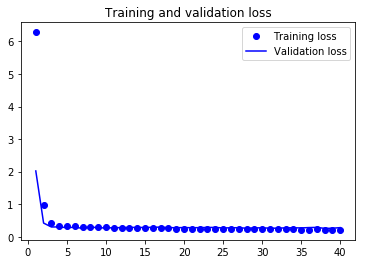

In [127]:
epochs = range(1, 41)
plt.figure()
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

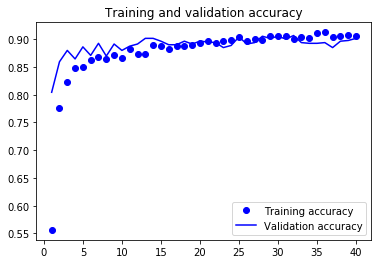

In [128]:
plt.figure()
plt.plot(epochs, history.history['acc'], 'bo', label='Training accuracy')
plt.plot(epochs, history.history['val_acc'], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

It can be observed that after the fifth epoc the validation loss starts to decrease dramatically. Also the training curves are closely tracking the validation curves.

First lets load the model

In [137]:
model.load_weights('models/ffn.hdf5')

Now lets display the acccuracy, precision, recall, and fscore.

In [139]:
def evaluate(model, x_test, y_test):
    y_pred = model.predict_classes(x_test)

    score, accuracy = model.evaluate(x_test, y_test, batch_size=32)
    print "\nAccuracy:", accuracy

    p = precision_score(y_test, y_pred)
    r = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print "Precision:", p
    print "Recall:", r
    print "F-Score:", f1
    print "Confusion Matrix:"
    print confusion_matrix(y_test, y_pred)
    
evaluate(model, x_test, y_test)

416/782 [==============>...............] - ETA: 0s 
Accuracy: 0.901534526854
Precision: 0.952459016393
Recall: 0.923688394277
F-Score: 0.937853107345
Confusion Matrix:
[[124  29]
 [ 48 581]]


Even if the neural network implemented was extremly simple, surprisingly we are getting some incredible results.

### Refinement

In this section we will use GridSearch, to train separate instances of a model with distinct hyperparameters. Then, we will compare results to identify which combination of parameters produces the best resutls.

For this, we will use Scikit-Learn GridSearch funcionality. The sample implementation on how to adapt a Keras model with GridSearch can be found on this [link](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras)

In [131]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

model = KerasClassifier(build_fn=create_model)

epochs = [10, 20, 30, 40]
dropout_rate = [0.1, 0.2, 0.3, 0.4, 0.5]
param_grid = dict(dropout_rate=dropout_rate, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1')

grid_result = grid.fit(x_train, y_train)

print "Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)

Epoch 1/10
1562/1562 [==============================] - 3s - loss: 5.1562 - acc: 0.6248     
Epoch 2/10
1562/1562 [==============================] - 0s - loss: 3.2140 - acc: 0.7843     
Epoch 3/10
1562/1562 [==============================] - 0s - loss: 3.0838 - acc: 0.7657     
Epoch 4/10
1562/1562 [==============================] - 0s - loss: 1.6611 - acc: 0.7484     
Epoch 5/10
1562/1562 [==============================] - 0s - loss: 1.0000 - acc: 0.7670     
Epoch 6/10
1562/1562 [==============================] - 0s - loss: 0.5898 - acc: 0.8041     
Epoch 7/10
1562/1562 [==============================] - 0s - loss: 0.4561 - acc: 0.8361     
Epoch 8/10
1562/1562 [==============================] - 0s - loss: 0.3844 - acc: 0.8348     
Epoch 9/10
1562/1562 [==============================] - 0s - loss: 0.3347 - acc: 0.8585     
Epoch 10/10
1563/1563 [==============================] - 3s - loss: 3.0873 - acc: 0.7415     
Epoch 2/10
1563/1563 [==============================] - 0s - loss: 1.

1563/1563 [==============================] - 0s - loss: 0.2585 - acc: 0.8791     
Epoch 16/20
1563/1563 [==============================] - 0s - loss: 0.2443 - acc: 0.8944     
Epoch 17/20
1563/1563 [==============================] - 0s - loss: 0.2509 - acc: 0.8874     
Epoch 18/20
1563/1563 [==============================] - 0s - loss: 0.2517 - acc: 0.8836     
Epoch 19/20
1563/1563 [==============================] - 0s - loss: 0.2348 - acc: 0.8944     
Epoch 20/20
1562/1562 [==============================] - 3s - loss: 12.7645 - acc: 0.2081     
Epoch 2/30
1562/1562 [==============================] - 0s - loss: 12.7645 - acc: 0.2081     
Epoch 3/30
1562/1562 [==============================] - 0s - loss: 9.0242 - acc: 0.4238     
Epoch 4/30
1562/1562 [==============================] - 0s - loss: 3.2941 - acc: 0.7919     
Epoch 5/30
1562/1562 [==============================] - 0s - loss: 3.1908 - acc: 0.7913     
Epoch 6/30
1562/1562 [==============================] - 0s - loss: 2.8549 

1563/1563 [==============================] - 0s - loss: 0.2094 - acc: 0.9143     
Epoch 35/40
1563/1563 [==============================] - 0s - loss: 0.2066 - acc: 0.9143     
Epoch 36/40
1563/1563 [==============================] - 0s - loss: 0.2064 - acc: 0.9155     
Epoch 37/40
1563/1563 [==============================] - 0s - loss: 0.2160 - acc: 0.9047     
Epoch 38/40
1563/1563 [==============================] - 0s - loss: 0.2216 - acc: 0.9098     
Epoch 39/40
1563/1563 [==============================] - 0s - loss: 0.2104 - acc: 0.9117     
Epoch 40/40
1563/1563 [==============================] - 3s - loss: 3.8836 - acc: 0.6878     
Epoch 2/40
1563/1563 [==============================] - 0s - loss: 1.6609 - acc: 0.7601     
Epoch 3/40
1563/1563 [==============================] - 0s - loss: 0.8605 - acc: 0.7837     
Epoch 4/40
1563/1563 [==============================] - 0s - loss: 0.5119 - acc: 0.8407     
Epoch 5/40
1563/1563 [==============================] - 0s - loss: 0.4267 -

1563/1563 [==============================] - 0s - loss: 3.1736 - acc: 0.7978     
Epoch 3/30
1563/1563 [==============================] - 0s - loss: 3.1361 - acc: 0.8017     
Epoch 4/30
1563/1563 [==============================] - 0s - loss: 3.1568 - acc: 0.7997     
Epoch 5/30
1563/1563 [==============================] - 0s - loss: 3.1495 - acc: 0.7997     
Epoch 6/30
1563/1563 [==============================] - 0s - loss: 3.1569 - acc: 0.7997     
Epoch 7/30
1563/1563 [==============================] - 0s - loss: 3.1618 - acc: 0.7991     
Epoch 8/30
1563/1563 [==============================] - 0s - loss: 3.1655 - acc: 0.7991     
Epoch 9/30
1563/1563 [==============================] - 0s - loss: 3.1700 - acc: 0.8004     
Epoch 10/30
1563/1563 [==============================] - 0s - loss: 3.1598 - acc: 0.8010     
Epoch 11/30
1563/1563 [==============================] - 0s - loss: 3.1586 - acc: 0.8017     
Epoch 12/30
1563/1563 [==============================] - 0s - loss: 3.1399 - ac

1562/1562 [==============================] - 0s - loss: 0.2440 - acc: 0.9046     
Epoch 29/40
1562/1562 [==============================] - 0s - loss: 0.2312 - acc: 0.9161     
Epoch 30/40
1562/1562 [==============================] - 0s - loss: 0.2435 - acc: 0.9091     
Epoch 31/40
1562/1562 [==============================] - 0s - loss: 0.2336 - acc: 0.9078     
Epoch 32/40
1562/1562 [==============================] - 0s - loss: 0.2316 - acc: 0.9117     
Epoch 33/40
1562/1562 [==============================] - 0s - loss: 0.2354 - acc: 0.9104     
Epoch 34/40
1562/1562 [==============================] - 0s - loss: 0.2232 - acc: 0.9142     
Epoch 35/40
1562/1562 [==============================] - 0s - loss: 0.2248 - acc: 0.9085     
Epoch 36/40
1562/1562 [==============================] - 0s - loss: 0.2309 - acc: 0.9110     
Epoch 37/40
1562/1562 [==============================] - 0s - loss: 0.2446 - acc: 0.9072     
Epoch 38/40
1562/1562 [==============================] - 0s - loss: 0.23

1563/1563 [==============================] - 0s - loss: 2.4977 - acc: 0.7863     
Epoch 8/20
1563/1563 [==============================] - 0s - loss: 2.2910 - acc: 0.7972     
Epoch 9/20
1563/1563 [==============================] - 0s - loss: 2.4541 - acc: 0.8010     
Epoch 10/20
1563/1563 [==============================] - 0s - loss: 2.4119 - acc: 0.7908     
Epoch 11/20
1563/1563 [==============================] - 0s - loss: 2.4689 - acc: 0.7914     
Epoch 12/20
1563/1563 [==============================] - 0s - loss: 2.3260 - acc: 0.7953     
Epoch 13/20
1563/1563 [==============================] - 0s - loss: 2.5034 - acc: 0.7972     
Epoch 14/20
1563/1563 [==============================] - 0s - loss: 0.5254 - acc: 0.8010     
Epoch 15/20
1563/1563 [==============================] - 0s - loss: 0.3635 - acc: 0.8337     
Epoch 16/20
1563/1563 [==============================] - 0s - loss: 0.3406 - acc: 0.8369     
Epoch 17/20
1563/1563 [==============================] - 0s - loss: 0.3412

1563/1563 [==============================] - 0s - loss: 0.2368 - acc: 0.8932     
Epoch 29/40
1563/1563 [==============================] - 0s - loss: 0.2264 - acc: 0.9028     
Epoch 30/40
1563/1563 [==============================] - 0s - loss: 0.2355 - acc: 0.8932     
Epoch 31/40
1563/1563 [==============================] - 0s - loss: 0.2331 - acc: 0.8944     
Epoch 32/40
1563/1563 [==============================] - 0s - loss: 0.2268 - acc: 0.9008     
Epoch 33/40
1563/1563 [==============================] - 0s - loss: 0.2403 - acc: 0.8957     
Epoch 34/40
1563/1563 [==============================] - 0s - loss: 0.2163 - acc: 0.9053     
Epoch 35/40
1563/1563 [==============================] - 0s - loss: 0.2371 - acc: 0.8970     
Epoch 36/40
1563/1563 [==============================] - 0s - loss: 0.2286 - acc: 0.8996     
Epoch 37/40
1563/1563 [==============================] - 0s - loss: 0.2201 - acc: 0.9034     
Epoch 38/40
1563/1563 [==============================] - 0s - loss: 0.22

1562/1562 [==============================] - 0s - loss: 0.2562 - acc: 0.9033     
Epoch 28/30
1562/1562 [==============================] - 0s - loss: 0.2576 - acc: 0.9059     
Epoch 29/30
1562/1562 [==============================] - 0s - loss: 0.2534 - acc: 0.9033     
Epoch 30/30
1563/1563 [==============================] - 4s - loss: 3.3681 - acc: 0.7774     
Epoch 2/30
1563/1563 [==============================] - 0s - loss: 3.1682 - acc: 0.8004     
Epoch 3/30
1563/1563 [==============================] - 0s - loss: 3.1613 - acc: 0.8004     
Epoch 4/30
1563/1563 [==============================] - 0s - loss: 3.1488 - acc: 0.7985     
Epoch 5/30
1563/1563 [==============================] - 0s - loss: 3.1211 - acc: 0.7985     
Epoch 6/30
1563/1563 [==============================] - 0s - loss: 3.1231 - acc: 0.7869     
Epoch 7/30
1563/1563 [==============================] - 0s - loss: 3.0639 - acc: 0.7895     
Epoch 8/30
1563/1563 [==============================] - 0s - loss: 2.9965 - ac

1563/1563 [==============================] - 0s - loss: 0.3151 - acc: 0.8189     
Epoch 29/40
1563/1563 [==============================] - 0s - loss: 0.3134 - acc: 0.8202     
Epoch 30/40
1563/1563 [==============================] - 0s - loss: 0.3036 - acc: 0.8311     
Epoch 31/40
1563/1563 [==============================] - 0s - loss: 0.2892 - acc: 0.8375     
Epoch 32/40
1563/1563 [==============================] - 0s - loss: 0.3002 - acc: 0.8260     
Epoch 33/40
1563/1563 [==============================] - 0s - loss: 0.2891 - acc: 0.8285     
Epoch 34/40
1563/1563 [==============================] - 0s - loss: 0.2994 - acc: 0.7946     
Epoch 35/40
1563/1563 [==============================] - 0s - loss: 0.2872 - acc: 0.7985     
Epoch 36/40
1563/1563 [==============================] - 0s - loss: 0.2899 - acc: 0.8369     
Epoch 37/40
1563/1563 [==============================] - 0s - loss: 0.2813 - acc: 0.8522     
Epoch 38/40
1563/1563 [==============================] - 0s - loss: 0.28

1563/1563 [==============================] - 0s - loss: 0.4140 - acc: 0.8055     
Epoch 8/30
1563/1563 [==============================] - 0s - loss: 0.3673 - acc: 0.8234     
Epoch 9/30
1563/1563 [==============================] - 0s - loss: 0.3607 - acc: 0.8273     
Epoch 10/30
1563/1563 [==============================] - 0s - loss: 0.3646 - acc: 0.8151     
Epoch 11/30
1563/1563 [==============================] - 0s - loss: 0.3544 - acc: 0.8349     
Epoch 12/30
1563/1563 [==============================] - 0s - loss: 0.3569 - acc: 0.8279     
Epoch 13/30
1563/1563 [==============================] - 0s - loss: 0.3576 - acc: 0.8241     
Epoch 14/30
1563/1563 [==============================] - 0s - loss: 0.3449 - acc: 0.8349     
Epoch 15/30
1563/1563 [==============================] - 0s - loss: 0.3420 - acc: 0.8247     
Epoch 16/30
1563/1563 [==============================] - 0s - loss: 0.3413 - acc: 0.8311     
Epoch 17/30
1563/1563 [==============================] - 0s - loss: 0.3339

2344/2344 [==============================] - 0s - loss: 0.2249 - acc: 0.8980     
Epoch 29/40
2344/2344 [==============================] - 0s - loss: 0.2260 - acc: 0.8997     
Epoch 30/40
2344/2344 [==============================] - 0s - loss: 0.2312 - acc: 0.8985     
Epoch 31/40
2344/2344 [==============================] - 0s - loss: 0.2217 - acc: 0.9010     
Epoch 32/40
2344/2344 [==============================] - 0s - loss: 0.2222 - acc: 0.9078     
Epoch 33/40
2344/2344 [==============================] - 0s - loss: 0.2118 - acc: 0.9049     
Epoch 34/40
2344/2344 [==============================] - 0s - loss: 0.2276 - acc: 0.9036     
Epoch 35/40
2344/2344 [==============================] - 0s - loss: 0.2201 - acc: 0.9104     
Epoch 36/40
2344/2344 [==============================] - 0s - loss: 0.2161 - acc: 0.9083     
Epoch 37/40
2344/2344 [==============================] - 0s - loss: 0.2185 - acc: 0.9044     
Epoch 38/40
2344/2344 [==============================] - 0s - loss: 0.20

It looks like that by random chance the default parameters used to train the model turnout to be best ones :)